Link to training loop cell: [here](https://colab.research.google.com/drive/1GnEkllKALTGpAIMmaC-YwnBYT04bpIEK#scrollTo=dZowNAuMhfkw&line=1&uniqifier=1)

Standard imports

In [1]:
!nvidia-smi

Tue Feb 22 12:50:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
from torchsummary import summary

from torch.nn import Module, Conv2d, MaxPool2d, Linear, ReLU, LogSoftmax

from torch.nn import LayerNorm, BatchNorm2d, Dropout

import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.nn.functional import normalize

import torchvision
import torchvision.transforms as transforms

import cv2
import matplotlib.pyplot as plt
import dlib
import imutils
import numpy as np
import math

from google.colab.patches import cv2_imshow
from imutils import face_utils
import pickle

Mount drive

In [3]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [4]:
global feature_vector
feature_vector = np.array([])

Rectangle to bounding box

In [5]:
def rect_to_bb(rect):
  '''
   take a bounding box and convert it to 
   (x, y, w, h) coordinates
   returns a tuple of coordinates (x, y, w, h)
  '''
  x = rect.left()
  y = rect.top()
  w = rect.right() - x
  h = rect.bottom() - y

  global feature_vector
  if len(feature_vector) == 0:
    feature_vector = np.append(feature_vector, [x, y, w, h])

  return (x, y, w, h)

Coordinates of facial landmarks

In [6]:
def shape_to_np(shape, dtype = "int"):
  # initialize all coordinates to 0 (68 facial landmarks)
  coordinates = np.zeros((6,2), dtype = dtype)

  for i in range (0, 68):
    coordinates[i] = (shape.part(i).x, shape.part(j).y)
  
  return coordinates

Detect facial landmarks 

In [7]:
global landmark
landmark = np.array([])
def landmarks(path_to_image):
  detector  = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor('/content/drive/MyDrive/DGAZE/shape_predictor.dat')

  image = cv2.imread(path_to_image)
  image = imutils.resize(image, width = 500) # resize the image

  # convert to grayscale
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # detect faces in the grayscale image
  rects = detector(gray, 1) 

  # loop over all face detections
  for (i, rect) in enumerate(rects):
    # detect facial landmarks and convert
    # to a numpy array
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)
    global landmark
    landmark = np.array([shape[36], shape[45], shape[30], shape[48],shape[54], shape[8]])

    # this portion of the code extracts the left eye image
    facial_features_dict = face_utils.FACIAL_LANDMARKS_IDXS
    left_eye_coords = facial_features_dict['left_eye'] 
    (i, j) = left_eye_coords
    # extract ROI of the face
    (x, y, w, h) = cv2.boundingRect(np.array([shape[i:j]]))
    left_eye = image[y:y+h, x:x+w]
    left_eye = imutils.resize(left_eye, width = 60, height = 36, inter=cv2.INTER_CUBIC)
    left_eye_resize = cv2.resize(left_eye, dsize=(60, 36), interpolation=cv2.INTER_CUBIC)

    # draw bounding box around the face
    (x, y, w, h) = rect_to_bb(rect)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # draw facial landmarks
    for (x, y) in landmark:
      cv2.circle(image, (x, y), 1, (0, 0, 255), -1)
    
    if landmark.shape[1] != 3:
      landmark = np.append(landmark, [[0],
                                      [0],
                                      [0],
                                      [0],
                                      [0],
                                      [0]], axis=1)
      
      return left_eye_resize
    

Predict roll, pitch and yaw angles using OpenCV

In [8]:
def face_orientation(frame, landmarks):
    size = frame.shape #(height, width, color_channel)

    image_points = np.array([
                            (landmarks[2][0], landmarks[2][1]),     # Nose tip
                            (landmarks[5][0], landmarks[5][1]),     # Chin
                            (landmarks[0][0], landmarks[0][1]),     # Left eye left corner
                            (landmarks[1][0], landmarks[1][1]),     # Right eye right corne
                            (landmarks[3][0], landmarks[3][1]),     # Left Mouth corner
                            (landmarks[4][0], landmarks[4][1])      # Right mouth corner
                        ], dtype = float)

    

                        
    model_points = np.array([
                            (0.0, 0.0, 0.0),             # Nose tip
                            (0.0, -330.0, -65.0),        # Chin
                            (-165.0, 170.0, -135.0),     # Left eye left corner
                            (165.0, 170.0, -135.0),      # Right eye right corne
                            (-150.0, -150.0, -125.0),    # Left Mouth corner
                            (150.0, -150.0, -125.0)      # Right mouth corner                         
                        ])

    # Camera internals
 
    center = (size[1]/2, size[0]/2)
    focal_length = center[0] / np.tan(60/2 * np.pi / 180)
    camera_matrix = np.array(
                         [[focal_length, 0, center[0]],
                         [0, focal_length, center[1]],
                         [0, 0, 1]], dtype = float
                         )

    dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
    (success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)

    
    axis = np.float32([[500,0,0], 
                          [0,500,0], 
                          [0,0,500]])
                          
    imgpts, jac = cv2.projectPoints(axis, rotation_vector, translation_vector, camera_matrix, dist_coeffs)
    modelpts, jac2 = cv2.projectPoints(model_points, rotation_vector, translation_vector, camera_matrix, dist_coeffs)
    rvec_matrix = cv2.Rodrigues(rotation_vector)[0]

    proj_matrix = np.hstack((rvec_matrix, translation_vector))
    eulerAngles = cv2.decomposeProjectionMatrix(proj_matrix)[6] 

    
    pitch, yaw, roll = [math.radians(_) for _ in eulerAngles]


    pitch = math.degrees(math.asin(math.sin(pitch)))
    roll = -math.degrees(math.asin(math.sin(roll)))
    yaw = math.degrees(math.asin(math.sin(yaw)))

    global feature_vector
    if len(feature_vector) == 4:
      feature_vector = np.append(feature_vector, [roll, pitch, yaw])

    return imgpts, modelpts, (str(int(roll)), str(int(pitch)), str(int(yaw))), (landmarks[2][0], landmarks[2][1])

In [9]:
def head_pose(img_path):
  frame = cv2.imread(img_path)
  frame = imutils.resize(frame, width = 500)
  landmarks =  landmark
    
  print(img_path)
  imgpts, modelpts, rotate_degree, nose = face_orientation(frame, landmarks)
    
  cv2.line(frame, nose, tuple(imgpts[1].ravel()), (0,255,0), 3) #GREEN
  cv2.line(frame, nose, tuple(imgpts[0].ravel()), (255,0,), 3) #BLUE
  cv2.line(frame, nose, tuple(imgpts[2].ravel()), (0,0,255), 3) #RED
    
  remapping = [2,3,0,4,5,1]
  '''for index in range(int(len(landmarks)/2)):
      random_color = tuple(np.random.random_integers(0,255,size=3))

      random_color = (int(random_color[0]), int(random_color[1]), int(random_color[2]))
      cv2.circle(frame, (landmarks[index*2][0], landmarks[index*2+1][0]), 5, random_color, -1)  
      cv2.circle(frame,  tuple(modelpts[remapping[index]].ravel().astype(int)), 2, random_color, -1)'''  
        
            
  #    cv2.putText(frame, rotate_degree[0]+' '+rotate_degree[1]+' '+rotate_degree[2], (10, 30),
  #                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0),
  #                thickness=2, lineType=2)
                
  for j in range(len(rotate_degree)):
      cv2.putText(frame, ('{:05.2f}').format(float(rotate_degree[j])), (10, 30 + (50 * j)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), thickness=2, lineType=2)

  #cv2.imwrite('test2/'+img_path.split('/')[1], frame)
  cv2_imshow(frame)

In [10]:
def img_preprocess(img_path):

  #Initializing the feature vector
  global feature_vector
  feature_vector = np.array([])

  left_eye = landmarks(img_path)

  head_pose(img_path)
  
  global landmark

  if len(feature_vector) == 7:
    feature_vector = np.append(feature_vector, landmark[0][0])
    feature_vector = np.append(feature_vector, landmark[0][1])

  if len(feature_vector) == 9:
    feature_vector = np.append(feature_vector, landmark[1][0])
    feature_vector = np.append(feature_vector, landmark[1][1])

  if len(feature_vector) == 11:
    feature_vector = np.append(feature_vector, landmark[2][0])
    feature_vector = np.append(feature_vector, landmark[2][1])

  return feature_vector, left_eye


/content/drive/MyDrive/DGAZE/sampled_imp/Imagep69p.bmp


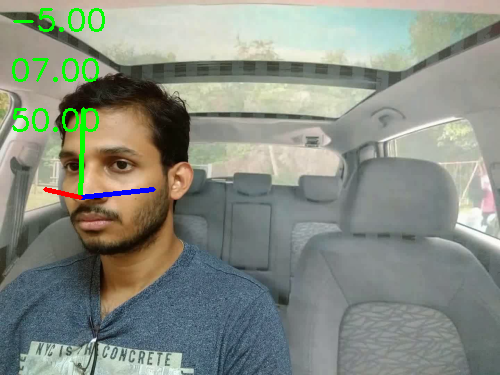

In [11]:
vector, eye = img_preprocess('/content/drive/MyDrive/DGAZE/sampled_imp/Imagep69p.bmp')
#print(vector)
#print(eye.shape)
#plt.imshow(eye)

# Gaze Mapping network

In [12]:
class GazeMapping(nn.Module):
  def __init__(self):
    super(GazeMapping, self).__init__()
    
    # left eye branch
    self.left_eye = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=20, kernel_size=(3, 3), stride=1, padding=0),
        nn.BatchNorm2d(num_features=20),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0),
        nn.Dropout(p=0.2),
        nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(3, 3), stride=1, padding=0),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0)
    )

    # feature branch
    self.dense1_1 = Linear(in_features=13, out_features=16) 

    # fused branch
    self.fusion = nn.Sequential(
            nn.Linear(in_features=4566, out_features=500),
            nn.ReLU(),
            nn.Linear(in_features=500, out_features=2)
        )

  def forward(self, x_eye, x_face):

    # forward pass on left eye branch
    x_left_fwd = self.left_eye(x_eye)

    x_left_flat = torch.flatten(x_left_fwd) # flatten left eye to 4550

    # fuse facial features and left eye image
    x_facial_flat = self.dense1_1(x_face) # transform to a vector of length 16
    x_facial_flat = torch.flatten(x_facial_flat)

    x_stack = torch.cat((x_left_flat, x_facial_flat), dim=0)
    x_stack = x_stack[0:4566] # prevent some weird double stacking

    # fusion branch
    x_final = self.fusion(x_stack)

    return x_final



### Sanity check

In [13]:
# convert to torch tensor and permute
eye_tensor = torch.from_numpy(eye)
eye_tensor = eye_tensor.permute(2, 0, 1)
print(eye_tensor.shape)


feature_vector_tensor = torch.from_numpy(vector)
feature_vector_tensor = feature_vector_tensor[None]
print(feature_vector_tensor.shape)

torch.Size([3, 36, 60])
torch.Size([1, 13])


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
##model = GazeMapping()
model = GazeMapping().to(device)
#list  = [eye_tensor.shape, feature_vector_tensor.shape]
# summary(model, [eye_tensor.shape, feature_vector_tensor.shape] )

cuda


# Our network

## Dense Block

In [15]:
class DenseBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DenseBlock, self).__init__()
    self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=3//2)
    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
    return torch.cat([x, self.relu(self.conv(x))], 1)

## Residual Dense Block (RDB)

In [16]:
class RDB(nn.Module):
  def __init__(self, in_channels, growth_rate, num_layers):
    super(RDB, self).__init__()
    self.layers = nn.Sequential(*[DenseBlock(in_channels + growth_rate * i, growth_rate) for i in range(num_layers)])

    # local fusion
    self.local_fusion = nn.Conv2d(in_channels=in_channels + growth_rate * num_layers, out_channels=growth_rate, kernel_size=1)

  def forward(self, x):
    # local residual connection
    return x + self.local_fusion(self.layers(x))

## Final network

In [17]:
class FinalNetwork(nn.Module):
  def __init__(self, num_channels, num_features, growth_rate, num_blocks, num_layers):
    super(FinalNetwork, self).__init__()
    self.feat = num_features
    self.growth = growth_rate
    self.blocks = num_blocks
    self.layers = num_layers

    # initial feature extraction
    self.feat1 = nn.Conv2d(in_channels=num_channels, out_channels=num_features, kernel_size=3, padding=3//2)
    # self.feat2 = nn.Conv2d(in_channels=num_channels, out_channels=num_features, kernel_size=3, padding=3//2)
    self.feat2 = nn.Conv2d(in_channels=num_features, out_channels=num_features, kernel_size=3, padding=3//2)

    # residual dense blocks
    self.RDBs = nn.ModuleList([RDB(in_channels=self.feat, growth_rate=self.growth, num_layers=self.layers)])
    for _ in range(self.blocks - 1):
      self.RDBs.append(RDB(in_channels=self.growth, growth_rate=self.growth, num_layers=self.layers))

    # global fusion
    self.global_fusion = nn.Sequential(
        nn.Conv2d(in_channels=self.growth * self.blocks, out_channels=self.feat, kernel_size=1),
        nn.Conv2d(in_channels=self.feat, out_channels=self.feat, kernel_size=3, padding=3//2)
    )

    # final step to ensure that the final number of channels are 3
    self.d1 = nn.Conv2d(in_channels=self.feat, out_channels=self.feat//2, kernel_size=3, padding=3//2)
    self.d2 = nn.Conv2d(in_channels=self.feat//2, out_channels=self.feat//4, kernel_size=3, padding=3//2)
    self.d3 = nn.Conv2d(in_channels=self.feat//4, out_channels=3, kernel_size=3, padding=3//2)

  def forward(self, x):
    num_samples = x.shape[0]  # <----
    feat1 = self.feat1(x)
    feat2 = self.feat2(feat1)

    x = feat2
    local_feature_vector = []
    for i in range(self.blocks):
      x = self.RDBs[i](x)
      local_feature_vector.append(x)
      
    # global residual connection
    x = self.global_fusion(torch.cat(local_feature_vector, 1)) + feat1 

    x = self.d3(self.d2(self.d1(x)))

    return torch.reshape(x, (num_samples, -1))  # <----

    return torch.flatten(x)



In [18]:
class TrialNetwork(nn.Module):
  def __init__(self, num_channels=3, num_features=64, growth_rate=64, num_blocks=8, num_layers=8):
    super(TrialNetwork, self).__init__()

    self.num_channels = num_channels
    self.num_features = num_features
    self.growth_rate = growth_rate
    self.num_blocks = num_blocks
    self.num_layers = num_layers

    # left-eye branch
    self.left_eye = FinalNetwork(
        self.num_channels,
        self.num_features,
        self.growth_rate,
        self.num_blocks,
        self.num_layers
    )

    # feature branch
    self.dense1_1 = Linear(in_features=13, out_features=16) 

    # fused branch
    self.fusion = nn.Sequential(
            nn.Linear(in_features=6496, out_features=500),
            nn.ReLU(),
            nn.Linear(in_features=500, out_features=2)
        )
    

  def forward(self, x_eye, x_face):

    # forward pass on left eye branch
    x_left_fwd = self.left_eye(x_eye)
    # print(x_left_fwd.shape)
    # x_left_flat = torch.flatten(x_left_fwd) # flatten left eye to 4550
    # print(x_left_flat.shape)
    # fuse facial features and left eye image
    x_face = self.dense1_1(x_face) # transform to a vector of length 16
    # x_facial_flat = torch.flatten(x_facial_flat)
    # print(x_face.shape)
    x_face = x_face.reshape(-1, 16)
    # print(x_face.shape)
    x_stack = torch.cat((x_left_fwd, x_face), dim=1).to(device="cuda")
    # x_stack = x_stack[0:4566] # prevent some weird double stacking
    # print(x_stack.shape)

    # fusion branch
    x_final = self.fusion(x_stack)

    return x_final



## Putting it all together


In [ ]:

class OurNetwork(nn.Module):
    def __init__(self, num_channels=3, num_features=64, growth_rate=64, num_blocks=8, num_layers=8):
        super(OurNetwork, self).__init__()
        
        self.num_channels = num_channels
        self.num_features = num_features
        self.growth_rate = growth_rate
        self.num_blocks = num_blocks
        self.num_layers = num_layers

        self.eye_branch = FinalNetwork(
            self.num_channels,
            self.num_features,
            self.growth_rate,
            self.num_blocks,
            self.num_layers)
        
        # downsampling the eye vector so that the dimensions match with the feature vector 
        self.eye_shape = 6480  # flattened shape of the eye
        self.fusion_shape = 13 # same shape as the "features" vector
        self.eye_downsample = nn.Sequential(
            nn.Linear(in_features=self.eye_shape, out_features=self.eye_shape//4, bias=False),
            nn.BatchNorm1d(self.eye_shape//4),
            nn.ReLU(),
            nn.Linear(in_features=self.eye_shape//4, out_features=self.eye_shape//16, bias=False),
            nn.BatchNorm1d(self.eye_shape//16),
            nn.ReLU(),
            nn.Linear(in_features=self.eye_shape//16, out_features=self.fusion_shape, bias=False),
            nn.BatchNorm1d(self.fusion_shape),
            nn.ReLU()
        )
        
        # batch-norm fusion
        self.f1 = nn.Linear(in_features=self.fusion_shape, out_features=self.fusion_shape, bias=False)
        self.f2 = nn.Linear(in_features=self.fusion_shape, out_features=self.fusion_shape, bias=False)
        self.f3 = nn.Linear(in_features=self.fusion_shape, out_features=self.fusion_shape, bias=False)

        self.eye_fusion_branch = nn.Sequential(
            self.f1,
            nn.BatchNorm1d(self.fusion_shape),
            nn.ReLU(),
            self.f2,
            #nn.BatchNorm1d(self.fusion_shape),
            nn.ReLU(),
            self.f3,
            #nn.BatchNorm1d(self.fusion_shape),
            nn.ReLU()
        )
        
        self.features_fusion_branch = nn.Sequential(
            self.f1,
            nn.BatchNorm1d(self.fusion_shape),
            nn.ReLU(),
            self.f2,
            #nn.BatchNorm1d(self.fusion_shape),
            nn.ReLU(),
            self.f3,
            #nn.BatchNorm1d(self.fusion_shape),
            nn.ReLU()
        )
        
        # MLP layer
        self.mlp = nn.Sequential(
            nn.Linear(in_features=self.fusion_shape * 2, out_features=self.fusion_shape),
            nn.ReLU(),
            nn.Linear(in_features=self.fusion_shape, out_features=2)
        )
        
    def forward(self, x_eye, x_features):

      """
      x_eye.shape: (-1, 3, 36, 60)
      x_features.shape: (-1, 13)
      """
      print(x_eye.shape)
      print(x_features.shape)
      x_features = x_features.reshape(int(x_features.shape[0]), -1)

      x_eye = self.eye_branch(x_eye)
      x_eye = self.eye_downsample(x_eye)
      x_eye = self.eye_fusion_branch(x_eye)
       
      x_features = self.features_fusion_branch(x_features)
       
      print(x_features.shape)
      print(x_eye.shape)

      # x_features = x_features.reshape((list(x_eye.shape)))

      x_fusion = torch.stack((x_eye, x_features), dim=0).reshape(-1, self.fusion_shape * 2)
      print(x_fusion.shape)
        
      #out = x_eye
      out = x_fusion
      out = self.mlp(x_fusion)
      # print(out.shape)

      return out
        
        

Model Summary

In [ ]:
# tensor1 = torch.randn([1, 3, 36, 60])
# tensor2 = torch.randn(feature_vector_tensor.shape)
# tensor1.to("cpu")
# tensor2.to("cpu")

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = TrialNetwork(num_channels=3, num_features=32, growth_rate=32,num_blocks=4, num_layers=4).to(device)
#model.eval()
# summary(model, [eye_tensor.shape, feature_vector_tensor.shape] )
#model_out = model(tensor1, tensor2)
#summary(model, eye_tensor.shape)

cuda


In [ ]:
#model_out

#helper funcs.

# Creating a dataset class to pass into train_loader




In [20]:
import os
from tqdm import tqdm
from PIL import Image
import glob
from IPython.display import display
import pandas as pd
import numpy as np
import string
alphabet_string = string.ascii_lowercase
alphabet= list(alphabet_string)

class Dgaze_DataSet():
  
   def __init__(self):
        samples_per_vid = 20
        self.image_list = []   
        self.txt_list1 =  sorted(glob.glob("/content/drive/MyDrive/DGAZE/road_view/*.txt"))
        #self.txt_list2 =  sorted(glob.glob("/content/drive/MyDrive/DGAZE/road_view/*.npy"))
        #self.txt_list = self.txt_list1+self.txt_list2
        #self.txt_list.sort()
        self.labels=[]
        for i in range(len(self.txt_list1)):
          df = pd.read_csv(self.txt_list1[i], header = None)
          for j in range(samples_per_vid):
          
            label_arr = np.array([(df.iloc[j][1]+df.iloc[j][3])/2, (df.iloc[j][2]+df.iloc[j][4])/2])
            lab_tensor = torch.from_numpy(label_arr).to(device=device)
            self.labels = self.labels + [lab_tensor]
        self.labels = self.labels*11
        for i in range(6,24):
          # 7, 14, 17, 18, 20, 22, 13
          if(i not in (7, 13, 14, 17, 18, 20, 22)):
            file_name = "/content/drive/MyDrive/DGAZE/full_list"+str(i)
            open_file = open(file_name, "rb")
            list_f = pickle.load(open_file)
            for i in list_f:
              #i[0]= normalize(i[0], p=2.0, dim=1).to(device=device)
              #i[1]= normalize(i[1], p=2.0, dim=1).to(device=device)
                  min_ele = torch.min(i[0])
                  i[0] -= min_ele
                  i[0] /= torch.max(i[0])
                  i[0] = i[0].to(device=device)
                  min_ele1 = torch.min(i[1])
                  i[1] -= min_ele1
                  i[1] /= torch.max(i[1])
                  i[1] = i[1].to(device=device)
            print(i, len(list_f))
            self.image_list=self.image_list+list_f
            open_file.close()
            
        #for i in range(12,13):

          #for filename in sorted(glob.glob('/content/drive/MyDrive/DGAZE/im'+str(alphabet[i])+'/*.bmp')): 
        #for filename in sorted(glob.glob('/content/drive/MyDrive/DGAZE/sampled_imp/*.bmp')): 
            #im=filename
            #vector, eye = img_preprocess(im)
            #eye_tensor = torch.from_numpy(eye).float()
            #eye_tensor = eye_tensor.permute( 2, 0, 1)
            #eye_tensor = eye_tensor.to(device=device)
         # eye_tensor = torch.reshape(eye_tensor, (1,3,36,60))
           # feature_vector_tensor = torch.from_numpy(vector).float()
           # feature_vector_tensor = feature_vector_tensor[None,None].to(device=device)
           # self.image_list = self.image_list + [[eye_tensor,feature_vector_tensor]]
          #eye_tensor = torch.reshape(feature_vector_tensor, (1,1,1,13))
        #self.image_list = driver_imglist
          #self.image_tensor = torch.FloatTensor(self.image_list)
   def __getitem__(self,index):
        return self.image_list[index], self.labels[index]
   def get_list(self):
     return self.txt_list1  
   def __len__(self):
        return len(self.labels)    
       

In [21]:
with open("/content/drive/MyDrive/DGAZE/full_list22", "rb") as fp:   # Unpickling  
    driver_imglist = pickle.load(fp)
len(driver_imglist)

2060

In [22]:
class Dgaze_ValSet():
  
   def __init__(self):
        samples_per_vid = 20
        no_of_drivers = 1
        self.image_list = []   
        self.txt_list1 =  sorted(glob.glob("/content/drive/MyDrive/DGAZE/road_view/*.txt"))
        #self.txt_list2 =  sorted(glob.glob("/content/drive/MyDrive/DGAZE/road_view/*.npy"))
        #self.txt_list = self.txt_list1+self.txt_list2
        #self.txt_list.sort()
        self.labels=[]
        for i in range(len(self.txt_list1)):
          df = pd.read_csv(self.txt_list1[i], header = None)
          for j in range(samples_per_vid):
          
            label_arr = np.array([(df.iloc[j][1]+df.iloc[j][3])/2, (df.iloc[j][2]+df.iloc[j][4])/2])
            lab_tensor = torch.from_numpy(label_arr).to(device=device)
            self.labels = self.labels + [lab_tensor]
        self.labels = self.labels*no_of_drivers 
        for i in range(6,24):
          # 7, 14, 17, 18, 20, 22, 13
          if(i in (22,25)):
            file_name = "/content/drive/MyDrive/DGAZE/full_list"+str(i)
            open_file = open(file_name, "rb")
            list_f = pickle.load(open_file)
            for i in list_f:
              #i[0]= normalize(i[0], p=2.0, dim=1).to(device=device)
              #i[1]= normalize(i[1], p=2.0, dim=1).to(device=device)
                  min_ele = torch.min(i[0])
                  i[0] -= min_ele
                  i[0] /= torch.max(i[0])
                  i[0] = i[0].to(device=device)
                  min_ele1 = torch.min(i[1])
                  i[1] -= min_ele1
                  i[1] /= torch.max(i[1])
                  i[1] = i[1].to(device=device)
            print(i, len(list_f))
            self.image_list=self.image_list+list_f
            open_file.close()
            
        #for i in range(12,13):

          #for filename in sorted(glob.glob('/content/drive/MyDrive/DGAZE/im'+str(alphabet[i])+'/*.bmp')): 
        #for filename in sorted(glob.glob('/content/drive/MyDrive/DGAZE/sampled_imp/*.bmp')): 
            #im=filename
            #vector, eye = img_preprocess(im)
            #eye_tensor = torch.from_numpy(eye).float()
            #eye_tensor = eye_tensor.permute( 2, 0, 1)
            #eye_tensor = eye_tensor.to(device=device)
         # eye_tensor = torch.reshape(eye_tensor, (1,3,36,60))
           # feature_vector_tensor = torch.from_numpy(vector).float()
           # feature_vector_tensor = feature_vector_tensor[None,None].to(device=device)
           # self.image_list = self.image_list + [[eye_tensor,feature_vector_tensor]]
          #eye_tensor = torch.reshape(feature_vector_tensor, (1,1,1,13))
        #self.image_list = driver_imglist
          #self.image_tensor = torch.FloatTensor(self.image_list)
   def __getitem__(self,index):
        return self.image_list[index], self.labels[index]
   def get_list(self):
     return self.txt_list1  
   def __len__(self):
        return len(self.labels)   

In [23]:
class Dgaze_TestSet():
  
   def __init__(self):
        samples_per_vid = 20
        no_of_drivers = 1
        self.image_list = []   
        self.txt_list1 =  sorted(glob.glob("/content/drive/MyDrive/DGAZE/road_view/*.txt"))
        #self.txt_list2 =  sorted(glob.glob("/content/drive/MyDrive/DGAZE/road_view/*.npy"))
        #self.txt_list = self.txt_list1+self.txt_list2
        #self.txt_list.sort()
        self.labels=[]
        for i in range(len(self.txt_list1)):
          df = pd.read_csv(self.txt_list1[i], header = None)
          #print(self.txt_list1[i])
          for j in range(samples_per_vid):
            if (self.txt_list1[i]=='/content/drive/MyDrive/DGAZE/road_view/trip79_out.txt'):
              if(j in (18,19)):
                break
            label_arr = np.array([(df.iloc[j][1]+df.iloc[j][3])/2, (df.iloc[j][2]+df.iloc[j][4])/2])
            lab_tensor = torch.from_numpy(label_arr).to(device=device)
            self.labels = self.labels + [lab_tensor]
        self.labels = self.labels*no_of_drivers 
        for i in range(6,24):
          # 7, 14, 17, 18, 20, 22, 13
          if(i ==17):
            file_name = "/content/drive/MyDrive/DGAZE/full_list"+str(i)
            open_file = open(file_name, "rb")
            list_f = pickle.load(open_file)
            for i in list_f:
              #i[0]= normalize(i[0], p=2.0, dim=1).to(device=device)
              #i[1]= normalize(i[1], p=2.0, dim=1).to(device=device)
                  min_ele = torch.min(i[0])
                  i[0] -= min_ele
                  i[0] /= torch.max(i[0])
                  i[0] = i[0].to(device=device)
                  min_ele1 = torch.min(i[1])
                  i[1] -= min_ele1
                  i[1] /= torch.max(i[1])
                  i[1] = i[1].to(device=device)
            print(i, len(list_f))
            self.image_list=self.image_list+list_f
            open_file.close()
            
        #for i in range(12,13):

          #for filename in sorted(glob.glob('/content/drive/MyDrive/DGAZE/im'+str(alphabet[i])+'/*.bmp')): 
        #for filename in sorted(glob.glob('/content/drive/MyDrive/DGAZE/sampled_imp/*.bmp')): 
            #im=filename
            #vector, eye = img_preprocess(im)
            #eye_tensor = torch.from_numpy(eye).float()
            #eye_tensor = eye_tensor.permute( 2, 0, 1)
            #eye_tensor = eye_tensor.to(device=device)
         # eye_tensor = torch.reshape(eye_tensor, (1,3,36,60))
           # feature_vector_tensor = torch.from_numpy(vector).float()
           # feature_vector_tensor = feature_vector_tensor[None,None].to(device=device)
           # self.image_list = self.image_list + [[eye_tensor,feature_vector_tensor]]
          #eye_tensor = torch.reshape(feature_vector_tensor, (1,1,1,13))
        #self.image_list = driver_imglist
          #self.image_tensor = torch.FloatTensor(self.image_list)
   def __getitem__(self,index):
        return self.image_list[index], self.labels[index]
   def get_list(self):
     return self.txt_list1  
   def __len__(self):
        return len(self.labels)   

In [24]:
datasetf = Dgaze_DataSet()
dataset_val = Dgaze_ValSet()
dataset_test = Dgaze_TestSet()

#len(dataset.labels)
#file_name = "/content/drive/MyDrive/DGAZE/full_list12"

# open_file = open(file_name, "wb")
# pickle.dump(dataset.image_list, open_file)
# open_file.close()

# open_file = open(file_name, "rb")
# list_12 = pickle.load(open_file)
# open_file.close()

# print(list_12)

[tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0147, 0.0074, 0.0000],
         ...,
         [0.1765, 0.1691, 0.1618,  ..., 0.2868, 0.2794, 0.2721],
         [0.1691, 0.1618, 0.1471,  ..., 0.2941, 0.2868, 0.2868],
         [0.1691, 0.1618, 0.1471,  ..., 0.2941, 0.2868, 0.2868]],

        [[0.0956, 0.0956, 0.0956,  ..., 0.0662, 0.0588, 0.0515],
         [0.0956, 0.0956, 0.0956,  ..., 0.0735, 0.0662, 0.0588],
         [0.0956, 0.0956, 0.0956,  ..., 0.0882, 0.0809, 0.0735],
         ...,
         [0.3309, 0.3235, 0.3088,  ..., 0.4632, 0.4632, 0.4632],
         [0.3235, 0.3162, 0.3088,  ..., 0.4779, 0.4706, 0.4706],
         [0.3235, 0.3162, 0.3088,  ..., 0.4779, 0.4779, 0.4706]],

        [[0.2132, 0.2059, 0.1985,  ..., 0.3235, 0.3162, 0.3088],
         [0.2132, 0.2059, 0.1985,  ..., 0.3235, 0.3235, 0.3162],
         [0.2059, 0.2059, 0.1985,  ..., 0.3382, 0.3309, 0

## RUN TILL HERE

In [25]:
print(len(datasetf.image_list))
print(len(datasetf.labels))
print(len(dataset_val.image_list))
print(len(dataset_val.labels))
print(len(dataset_test.image_list))
len(dataset_test.labels)

22660
22660
2060
2060
2058


2058

In [26]:
train_loader = torch.utils.data.DataLoader(datasetf, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=True)

In [ ]:
# train_data = []
# train_data.append([datasetf.image_list, datasetf.labels])
# train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=1)
#train_loader = torch.utils.data.DataLoader([ [datasetf.image_list[i], datasetf.labels[i]] for i in range(len(datasetf.labels))], shuffle=True, batch_size=1)


In [27]:
#print(dataset.image_list)
#print(dataset.image_list[8][1].shape)
#for img in dataset.image_list:
  #print(img[0].shape, img[1].shape)
print(datasetf.labels[0])
print(len(train_loader))
print(len(val_loader))
len(test_loader)

tensor([1604.5000,  416.5000], device='cuda:0', dtype=torch.float64)
709
65


65

# Reset model weights

In [ ]:
# helper function to reset model weights before training

def weight_reset(model):
  if isinstance(model, nn.Conv2d) or isinstance(model, nn.Linear):
    model.reset_parameters()

In [ ]:
model.apply(weight_reset)

# Initialize model weights

In [ ]:
# # helper function to initialize model weights (this needs changes)

def weight_init(model):
  if isinstance(model, nn.Conv2d) or isinstance(model, nn.Linear):
    torch.nn.init.xavier_uniform(model.weight.data)

In [ ]:
model.apply(weight_init)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """


TrialNetwork(
  (left_eye): FinalNetwork(
    (feat1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (feat2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (RDBs): ModuleList(
      (0): RDB(
        (layers): Sequential(
          (0): DenseBlock(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (relu): ReLU(inplace=True)
          )
          (1): DenseBlock(
            (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (relu): ReLU(inplace=True)
          )
          (2): DenseBlock(
            (conv): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (relu): ReLU(inplace=True)
          )
          (3): DenseBlock(
            (conv): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (relu): ReLU(inplace=True)
          )
        )
        (local_fusion): Conv2d(160, 32, kernel_size=(1, 1), stri

In [ ]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/DGAZE/saved_weights/baseline_weights_new.pth'))

In [ ]:
# for image_list, labels in train_loader:
#   # print('image_list=', image_list)
#   # print('labels=', labels)
#   print(len(image_list))

In [30]:
datasetf.labels

[tensor([1604.5000,  416.5000], device='cuda:0', dtype=torch.float64),
 tensor([1614.0000,  416.5000], device='cuda:0', dtype=torch.float64),
 tensor([1604.0000,  417.5000], device='cuda:0', dtype=torch.float64),
 tensor([1606.,  418.], device='cuda:0', dtype=torch.float64),
 tensor([1600.0000,  418.5000], device='cuda:0', dtype=torch.float64),
 tensor([1602.5000,  419.5000], device='cuda:0', dtype=torch.float64),
 tensor([1604.5000,  426.5000], device='cuda:0', dtype=torch.float64),
 tensor([1603.0000,  428.5000], device='cuda:0', dtype=torch.float64),
 tensor([1601.0000,  432.5000], device='cuda:0', dtype=torch.float64),
 tensor([1599.0000,  442.5000], device='cuda:0', dtype=torch.float64),
 tensor([1600.5000,  447.5000], device='cuda:0', dtype=torch.float64),
 tensor([1594.5000,  456.0000], device='cuda:0', dtype=torch.float64),
 tensor([1593.,  458.], device='cuda:0', dtype=torch.float64),
 tensor([1599.0000,  457.5000], device='cuda:0', dtype=torch.float64),
 tensor([1596.5000,  4

In [31]:
import datetime
from tqdm import tqdm 

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, scheduler):
    losses = []
   #k = 0
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        loop = tqdm(enumerate(train_loader), total=len(train_loader))
        for batch_idx, (image_list, labels) in loop:
            #image_list = image_list.to(device=device)            #actual images of dataset
            #labels = labels.to(device=device)        #to be extracted from numpy files when we create a datasetmg[0]
            image_list[0]= image_list[0].to(device=device) 
            image_list[1]= image_list[1].to(device=device) 

            #labels = labels.to(device=device) 
            #k = k+1
            #print(k)
            #print(image_list[1].shape)
            #for i in range(image_list[0].shape[0]):
              #img[0]=img[0].to(device=device) 
              #img[1]= img[1].to(device=device) 
              #print( img[0].shape, img[1].shape, img[0].shape, img[1].shape, img.shape)
            outputs = model(image_list[0], image_list[1])
            # print(outputs.shape)
            # print(labels.shape)
            #print(outputs.size, labels.size, image_list[0].size)
            #outputs = outputs
            #outputs_t = torch.FloatTensor(outputs).to(device=device)  
            #labels_t = torch.Float(labels).to(device=device)
            labels = labels.to(device=device)

            #print(outputs.shape, labels.shape)
            loss = loss_fn(outputs, labels)
            # print('outputs=', outputs)
            # print('labels=', labels)
            # print('loss=', loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # progress bar updates
            loop.set_description(f"Epoch [{epoch}/{n_epochs}]")
            loop.set_postfix(loss = loss.item())
            loss_train += loss.item()
        if epoch > 1:
          losses.append(loss_train / len(train_loader))
        scheduler.step()
        # if epoch % 1 == 0: 
        #   print('{} Epoch {}, Training loss {}'.format(
        #       datetime.datetime.now(), epoch,
        #       loss_train / len(train_loader)))
        torch.save(model.state_dict(), '/content/drive/MyDrive/DGAZE/saved_weights/final_network.pth')
    plt.title("Training loss")
    plt.plot(losses,label="train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [ ]:
#optimizer = optim.SGD(model.parameters(), lr=1e-5, weight_decay=0.0001)
optimizer = optim.Adam(model.parameters(), lr=1e-5, eps=1e-5)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [40,55], gamma=0.1)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min',
                                                 #factor=0.1, patience=2)
loss_fn = nn.L1Loss()

# Load weights from checkpoint

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/DGAZE/saved_weights/our_network_centered.pth'))

<All keys matched successfully>

In [ ]:
training_loop(  
    n_epochs = 60,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader, 
    scheduler = scheduler
)

# Save model parameters

In [ ]:
print("Optimizer state dictionary: ")
for var_name in model.state_dict():
  print(var_name, "\t", model.state_dict()[var_name])

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/DGAZE/saved_weights/our_network_centered.pth')

# Visualise results

## Dot settings

In [28]:
radius = 20 # radius of point
gt_point_color = (0, 255, 0) # green ground truth
predicted_point_color = (0, 0, 255) # red predicted label
thickness = -1

In [29]:
train_loader_vis = torch.utils.data.DataLoader(datasetf, batch_size=32, shuffle=False)

In [ ]:
print(len(train_loader_vis))
outputs_l = []
i =0
for image_list, labels in train_loader_vis:
  i = i+1
  if(i>10):
    break
  image_list[0]= image_list[0].to(device=device) 
  image_list[1]= image_list[1].to(device=device)   
  outputs = model(image_list[0], image_list[1])
  outputs = outputs[None].float()
  labels = labels.float()
  #outputs_l = outputs_l + [outputs] 
  print('output=', outputs)
  print('label=', labels)
  
 

709
output= tensor([[[1615.8578,  522.2076],
         [1626.8204,  434.9294],
         [1572.1919,  472.1845],
         [1521.9651,  548.7215],
         [1640.3745,  462.1279],
         [1633.0233,  426.3171],
         [1648.4995,  485.8826],
         [1613.1682,  455.2857],
         [1618.0194,  461.3057],
         [1590.7708,  449.4094],
         [1647.1179,  444.5075],
         [1655.7573,  501.6077],
         [1625.0680,  477.8056],
         [1611.9143,  452.6273],
         [1619.3445,  446.1582],
         [1596.2352,  429.9454],
         [1581.7249,  410.7056],
         [1602.6210,  427.4335],
         [1605.9158,  424.6343],
         [1601.1182,  424.3951],
         [1657.0990,  702.9151],
         [1649.0072,  752.2100],
         [1649.6196,  700.2588],
         [1663.0691,  742.4679],
         [1577.0579,  713.3354],
         [1589.9015,  755.5029],
         [1619.3728,  736.9789],
         [1616.3076,  775.8206],
         [1624.3180,  776.2339],
         [1621.6355,  754.5272]

In [30]:
%cd /content/drive/MyDrive/DGAZE/visualizations

/content/drive/.shortcut-targets-by-id/17gkQDRACj90T20UcXJnOQdep_TVfRp-u/DGAZE/visualizations


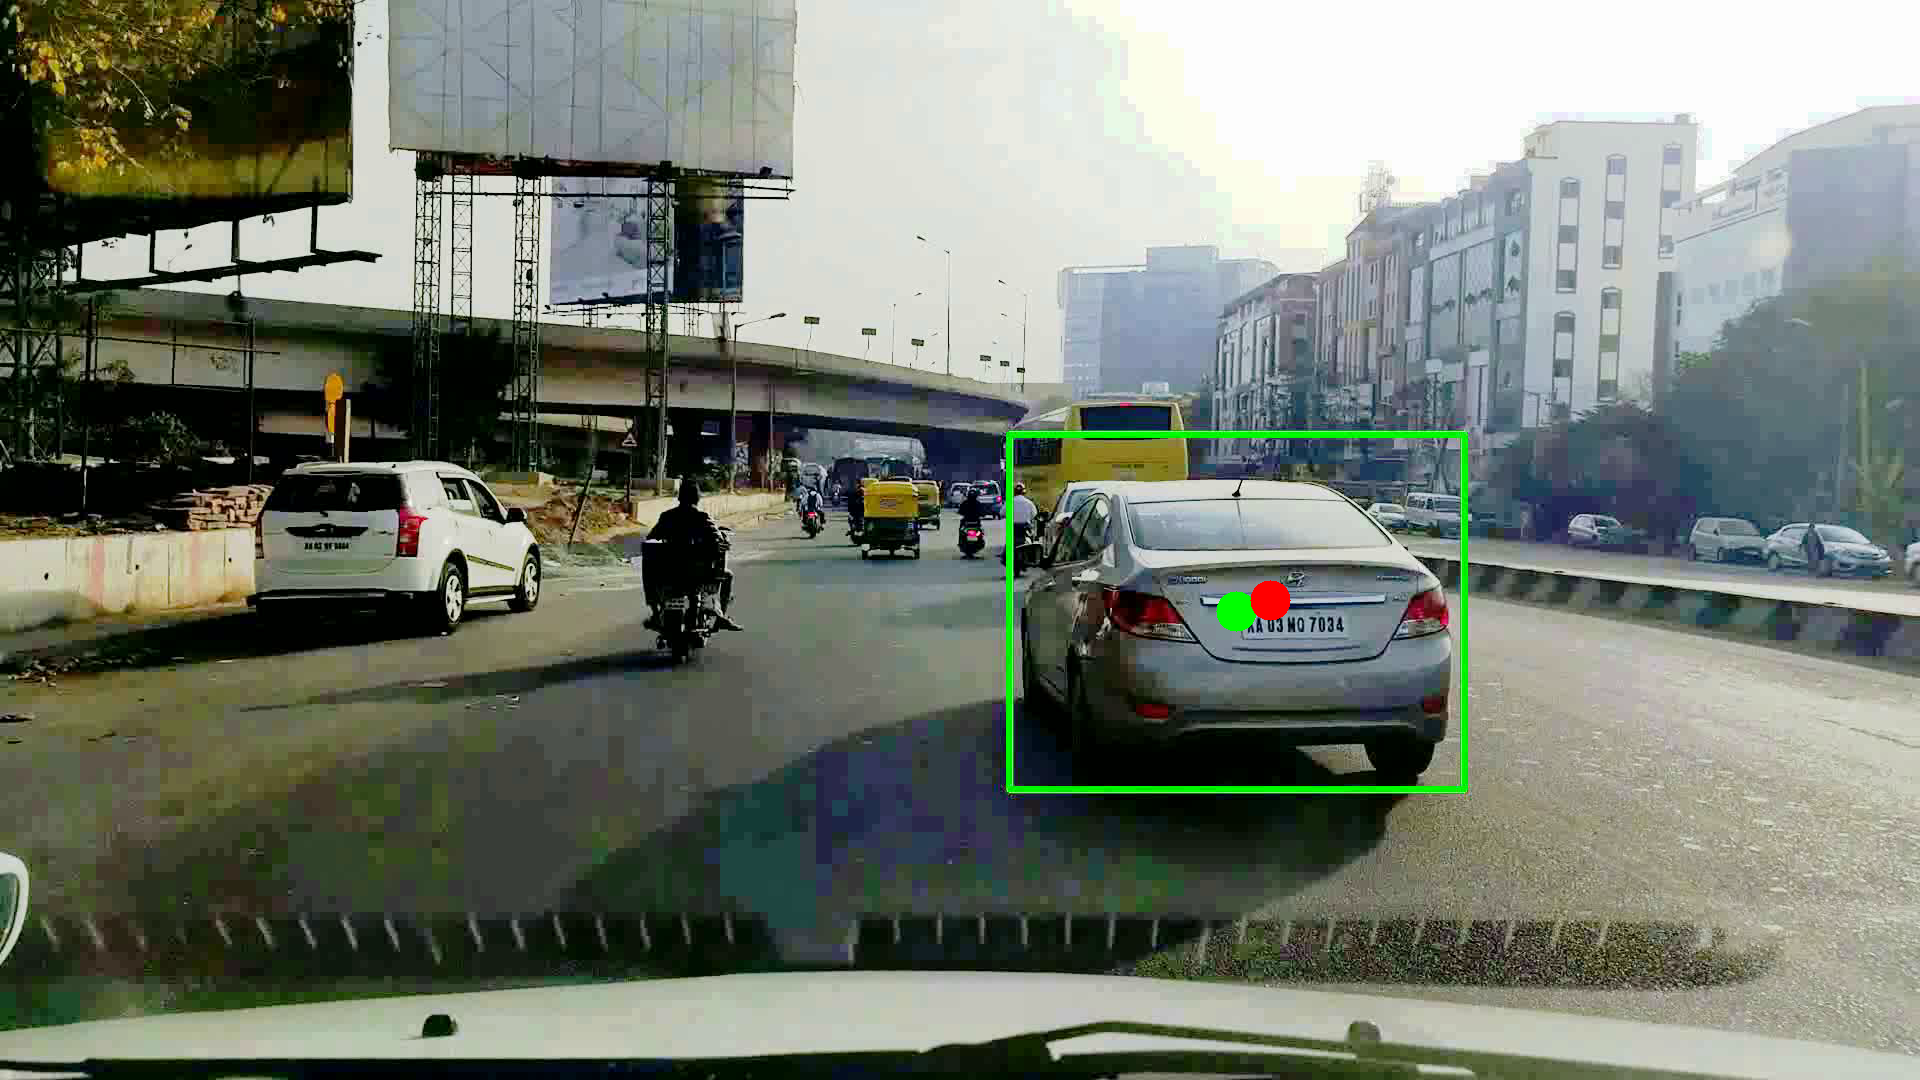

In [92]:
image1 = cv2.imread('/content/drive/MyDrive/DGAZE/sampled_road2/Image_road11.bmp')
ls = (datasetf.labels[280]).tolist()
ls_int = [int(x) for x in ls] 

center_gt = tuple(ls_int)
center_pred = tuple((1270, 600))
image1 = cv2.circle(image1, center_gt, radius, gt_point_color, thickness)
image = cv2.circle(image1, center_pred, radius, predicted_point_color, thickness)
cv2_imshow(image1)

In [93]:
cv2.imwrite('img9.jpg', image1)

True

In [ ]:
image2 = cv2.imread('/content/drive/MyDrive/DGAZE/sampled_road2/Image_road106.bmp')
center_gt = tuple((datasetf.labels[120]).tolist())
center_pred = (1156, 717)
image2 = cv2.circle(image2, center_gt, radius, gt_point_color, thickness)
image2 = cv2.circle(image2, center_pred, radius, predicted_point_color, thickness)
cv2_imshow(image2)

TypeError: ignored

In [ ]:
#txt_list1 =  sorted(glob.glob("/content/drive/MyDrive/DGAZE/road_view/*.npy"))
#data_array = []
#for i in range(len(txt_list1)):
#          data_array = data_array + [np.load(txt_list1[i])]
#data_array[8][0][0]

In [ ]:


'''class Dgaze_val():
  
   def __init__(self):
        
        self.image_list = []   
        self.txt_list1 =  sorted(glob.glob("/content/drive/MyDrive/DGAZE/road_view/*.npy"))
        #self.txt_list2 =  sorted(glob.glob("/content/drive/MyDrive/DGAZE/road_view/*.npy"))
        #self.txt_list = self.txt_list1+self.txt_list2
        #self.txt_list.sort()
        self.labels=[]
        for i in range(len(self.txt_list1)):
          data_arr = np.load(self.txt_list1[i])
          label_arr = data_arr[i]
          lab_tensor = torch.from_numpy(label_arr).to(device=device)
          self.labels = self.labels + [lab_tensor]
        self.labels = self.labels*18
        self.image_list = []
        for filename in sorted(glob.glob('/content/drive/MyDrive/DGAZE/val_set/*.bmp')): 
          im=filename
          vector, eye = img_preprocess(im)
          eye_tensor = torch.from_numpy(eye).float()
          eye_tensor = eye_tensor.permute( 2, 0, 1)
          eye_tensor = eye_tensor.to(device=device)
          #eye_tensor = torch.reshape(eye_tensor, (1,3,36,60))
          feature_vector_tensor = torch.from_numpy(vector).float()
          feature_vector_tensor = feature_vector_tensor[None,None].to(device=device)
          #eye_tensor = torch.reshape(feature_vector_tensor, (1,1,1,13))
          self.image_list = self.image_list + [eye_tensor, feature_vector_tensor]
        #self.image_list = driver_imglist
          #self.image_tensor = torch.FloatTensor(self.image_list)
   def __getitem__(self,index):
        return self.image_list[index], self.labels[index]
   def get_list(self):
     return self.txt_list1  
   def __len__(self):
        return len(self.txt_list1)'''   

In [ ]:
#data_val = Dgaze_val()

In [ ]:
#data_val.image_list

In [ ]:
#val_loader = torch.utils.data.DataLoader(Dgaze_val, batch_size=1, shuffle=False)

Link to validation class and val_loader: [here](https://colab.research.google.com/drive/1GnEkllKALTGpAIMmaC-YwnBYT04bpIEK#scrollTo=g-VoI1x41VMQ&line=2&uniqifier=1)

In [ ]:
def validate(model, train_loader, val_loader, test_loader):
    for name, loader in [("train", train_loader), ("val", val_loader),('test',test_loader)]:
        
        
        loss_n = 0
        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                imgs[0] = imgs[0].to(device=device)
                imgs[1] = imgs[1].to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs[0], imgs[1])
                
            #outputs_t = torch.FloatTensor(outputs).to(device=device)  
            #labels_t = torch.Float(labels).to(device=device)
        
            #print(outputs.shape, labels.shape, image_list[0].shape)
                loss = loss_fn(outputs, labels)

                loss_n += loss.item()
              

        print("Loss {}: {:.5f}".format(name , loss_n / len(loader)))



In [ ]:
validate(model, train_loader, val_loader, test_loader)

Loss train: 97.21397
Loss val: 194.64512
Loss test: 184.68969
